In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


import matplotlib.pyplot as plt
import tensorflow as tf

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# Load the data from the CSV file
aranet4 = pd.read_csv('../datasets/aranet4.csv')
aranetExp = pd.read_csv('../datasets/aranetExp.csv')

# Convert the date column to datetime
aranetExp['date'] = pd.to_datetime(aranetExp['date'])
aranetExp = aranetExp.rename(columns={'date': 'Datetime'})
aranetExp = aranetExp.drop(columns=['id','time'])
aranetExp = aranetExp.set_index('Datetime')

# Convert the date column to datetime 
aranet4['Datetime'] = pd.to_datetime(aranet4['Datetime'])
aranet4 = aranet4.set_index('Datetime')

# Create a copy of aranetExp
aranetExp_copy = aranetExp.copy()

# Round the 'Datetime' index to the nearest minute
aranetExp_copy.index = aranetExp_copy.index.round('min')
# Ensure each record has a unique datetime to the minute
unique_minutes = set()
for i in range(len(aranetExp_copy)):
    current_time = aranetExp_copy.index[i]
    original_time = current_time
    while current_time in unique_minutes:
        print(f"Changing {current_time} to ", end="")
        current_time += pd.Timedelta(minutes=1)
        print(f"{current_time}")
    if current_time != original_time:
        print(f"Original time {original_time} changed to {current_time}")
    unique_minutes.add(current_time)
    aranetExp_copy.index.values[i] = current_time
    
def custom_round_to_nearest_minute(dt_index):
    rounded_index = dt_index.floor('min') + pd.to_timedelta((dt_index.second >= 30).astype(int), unit='min')
    rounded_index.name = dt_index.name  # Preserve the name of the index
    return rounded_index

# Create a copy of aranet4
aranet4_copy = aranet4.copy()

# Use the custom function to round the 'Datetime' index to the nearest minute
aranet4_copy.index = custom_round_to_nearest_minute(aranet4_copy.index)

# Merge aranet4_copy with aranetExp_copy using an exact match on the 'Datetime' index
merged = pd.merge(aranet4_copy, aranetExp_copy, left_on='Datetime', right_index=True, how='left')


aranet_tf = merged.copy()
aranet_tf['hour'] = aranet_tf.index.hour
aranet_tf['minute'] = aranet_tf.index.minute


aranet = aranet_tf.copy()

# Filter the DataFrame to include all records from "2024-03-14 00:00:00" onwards
aranet_filtered = aranet.loc["2024-03-14 00:00:00":]


# Define a function to label the time periods as a boolean
def label_song_lec(row):
    if row.name.dayofweek in [0, 1, 2, 3]:  # Monday to Thursday
        if row.name.time() >= pd.to_datetime('12:15').time() and row.name.time() <= pd.to_datetime('13:30').time():
            return True
    return False

# Apply the function to the DataFrame
aranet_filtered['song_lec'] = aranet_filtered.apply(label_song_lec, axis=1)

def label_chen_lec(row):
    if row.name.dayofweek in [0, 2]:  # Monday and Wednesday
        if row.name.time() >= pd.to_datetime('09:00').time() and row.name.time() <= pd.to_datetime('10:15').time():
            return True
    elif row.name.dayofweek in [1, 3]:  # Tuesday and Thursday
        if row.name.time() >= pd.to_datetime('08:00').time() and row.name.time() <= pd.to_datetime('09:15').time():
            return True
    return False

aranet_filtered['chen_lec'] = aranet_filtered.apply(label_chen_lec, axis=1)

filtered_lec_df = aranet_filtered[(aranet_filtered['song_lec'] == True) | (aranet_filtered['chen_lec'] == True)]


# Initialize variables
sliced_dataframes = {}
lecture_start_time = None
lecture_type = None
lecture_count = {'song': 0, 'chen': 0}

# Iterate through the DataFrame
for index, row in filtered_lec_df.iterrows():
    # Check if we are in a new lecture
    if lecture_start_time is None or (index - lecture_start_time).total_seconds() > 75 * 60 or (row['song_lec'] and lecture_type != 'song') or (row['chen_lec'] and lecture_type != 'chen'):
        # Store the previous lecture if it exists
        if lecture_start_time is not None:
            lecture_label = f"{lecture_type}_lec_{lecture_count[lecture_type]}"
            # Subtract one minute from the end index of the slice
            sliced_dataframes[lecture_label] = filtered_lec_df.loc[lecture_start_time:index - pd.Timedelta(minutes=1)]
        
        # Update the lecture start time and type
        lecture_start_time = index
        if row['song_lec']:
            lecture_type = 'song'
        elif row['chen_lec']:
            lecture_type = 'chen'
        lecture_count[lecture_type] += 1

# Store the last lecture
if lecture_start_time is not None:
    lecture_label = f"{lecture_type}_lec_{lecture_count[lecture_type]}"
    # Subtract one minute from the end index of the last slice
    sliced_dataframes[lecture_label] = filtered_lec_df.loc[lecture_start_time:index - pd.Timedelta(minutes=1)]

# Display the keys of the sliced dataframes
print(sliced_dataframes.keys())


# Impute missing values in each lecture slice
# Iterate over each key (lecture) in the dictionary
for lecture_key in sliced_dataframes.keys():
    # Forward fill to impute missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].ffill()

    # Backward fill to impute remaining missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].bfill()



# Check if any column in the DataFrame has 0 non-null values

# Copy the keys to a list to avoid RuntimeError for changing dict size during iteration
keys_to_check = list(sliced_dataframes.keys())

# Store the lectures that will be removed
removed_lectures = []

for lecture_key in keys_to_check:
    # Check if any column in the DataFrame has 0 non-null values
    if (sliced_dataframes[lecture_key].count() == 0).any():
        # If found, add to the list of lectures to remove and delete from dictionary
        removed_lectures.append(lecture_key)
        del sliced_dataframes[lecture_key]

# Print the lectures that were removed
print("Lectures removed due to 0 non-null counts in all columns:", removed_lectures)

# Define a function to fill missing minutes in the DataFrame
def fill_missing_minutes_in_lectures(sliced_dataframes):
    for lecture_key, df in sliced_dataframes.items():
        # Get the minute column as a Series
        minutes = df.index.minute
        
        # Find the difference between consecutive minutes
        minute_diffs = minutes.to_series().diff().fillna(1)  # Fill the first NaN with 1
        
        # Identify indices where the difference is greater than 1
        missing_minute_indices = minute_diffs[minute_diffs > 1].index
        
        # For each missing minute, add a new row with NaN values
        for idx in missing_minute_indices:
            missing_time = df.index[idx - 1] + pd.Timedelta(minutes=1)
            empty_row = pd.DataFrame({col: np.nan for col in df.columns}, index=[missing_time])
            df = pd.concat([df, empty_row])
            print(f"Empty record created for {lecture_key} at {missing_time}")
        
        # Sort the DataFrame after adding new rows to maintain chronological order
        sliced_dataframes[lecture_key] = df.sort_index()
        
    return sliced_dataframes

# Apply the function
sliced_dataframes = fill_missing_minutes_in_lectures(sliced_dataframes)

def ensure_song_lecture_endpoints(sliced_dataframes):
    for lecture_key, df in sliced_dataframes.items():
        if 'song_lec' in lecture_key:
            # Check if the start and end points are missing
            start_time = df.index.min().replace(hour=12, minute=15, second=0)
            end_time = df.index.max().replace(hour=13, minute=30, second=0)

            if df.index.min() != start_time:
                # Add a new row at the start time with NaN values
                df.loc[start_time] = [np.nan] * len(df.columns)
                print(f"Start record created for {lecture_key} at {start_time}")

            if df.index.max() != end_time:
                # Add a new row at the end time with NaN values
                df.loc[end_time] = [np.nan] * len(df.columns)
                print(f"End record created for {lecture_key} at {end_time}")

            # Sort the DataFrame after adding new rows to maintain chronological order
            sliced_dataframes[lecture_key] = df.sort_index()

    return sliced_dataframes

# Apply the function
sliced_dataframes = ensure_song_lecture_endpoints(sliced_dataframes)

# Impute missing values in each lecture slice
# Iterate over each key (lecture) in the dictionary
for lecture_key in sliced_dataframes.keys():
    # Forward fill to impute missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].ffill()

    # Backward fill to impute remaining missing values
    sliced_dataframes[lecture_key] = sliced_dataframes[lecture_key].bfill()
    
    
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 1. Copy sliced_dataframes by subsetting the columns
model_set = {key: df[['Carbon dioxide(ppm)', 'door1', 'door2', 'hvac']].copy() for key, df in sliced_dataframes.items()}

# 2. Normalize 'Carbon dioxide(ppm)' and encode 'door1', 'door2', and 'hvac'
scaler = MinMaxScaler()

for key, df in model_set.items():
    # Normalize 'Carbon dioxide(ppm)'
    # Calculate the one-minute difference ('diff') and one-minute lag ('lag') for 'Carbon dioxide(ppm)'
    df['diff'] = df['Carbon dioxide(ppm)'].diff()
    df['diff'] = scaler.fit_transform(df[['diff']])
    df['Carbon dioxide(ppm)'] = scaler.fit_transform(df[['Carbon dioxide(ppm)']])

    # Encode 'door1', 'door2', and 'hvac'
    df['door1'] = df['door1'].map({'open': 1, 'closed': 0})
    df['door2'] = df['door2'].map({'open': 1, 'closed': 0})
    df['hvac'] = df['hvac'].map({'on': 1, 'off': 0})

    # Calculate the one-minute difference ('diff') and one-minute lag ('lag') for 'Carbon dioxide(ppm)'
    # df['diff'] = df['Carbon dioxide(ppm)'].diff()
    df['lag'] = df['Carbon dioxide(ppm)'].shift()

    # Drop NA values that result from diff and lag calculations
    df.dropna(inplace=True)
    # 1. Add 'lecturer' column based on the key        

# Check the data types and shapes after normalization, encoding, and feature creation
    print(f"{key}: {df.shape}")
    print(df.dtypes)

Changing 2024-03-13 13:08:00 to 2024-03-13 13:09:00
Original time 2024-03-13 13:08:00 changed to 2024-03-13 13:09:00
Changing 2024-03-18 12:25:00 to 2024-03-18 12:26:00
Original time 2024-03-18 12:25:00 changed to 2024-03-18 12:26:00
Changing 2024-03-18 12:26:00 to 2024-03-18 12:27:00
Original time 2024-03-18 12:26:00 changed to 2024-03-18 12:27:00
Changing 2024-03-19 09:18:00 to 2024-03-19 09:19:00
Original time 2024-03-19 09:18:00 changed to 2024-03-19 09:19:00
Changing 2024-03-25 10:18:00 to 2024-03-25 10:19:00
Original time 2024-03-25 10:18:00 changed to 2024-03-25 10:19:00
Changing 2024-04-02 12:34:00 to 2024-04-02 12:35:00
Original time 2024-04-02 12:34:00 changed to 2024-04-02 12:35:00
Changing 2024-04-04 12:30:00 to 2024-04-04 12:31:00
Original time 2024-04-04 12:30:00 changed to 2024-04-04 12:31:00
Changing 2024-04-08 12:31:00 to 2024-04-08 12:32:00
Original time 2024-04-08 12:31:00 changed to 2024-04-08 12:32:00
Changing 2024-04-08 12:32:00 to 2024-04-08 12:33:00
Original tim

C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_20692\3002810179.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aranet_filtered['song_lec'] = aranet_filtered.apply(label_song_lec, axis=1)
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_20692\3002810179.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aranet_filtered['chen_lec'] = aranet_filtered.apply(label_chen_lec, axis=1)
C:\Users\Corey Dearing\AppData\Local\Temp\ipykernel_20692\3002810179.py:179: FutureWarning: Behavior when concatenat

dict_keys(['chen_lec_1', 'song_lec_1', 'chen_lec_2', 'song_lec_2', 'chen_lec_3', 'song_lec_3', 'chen_lec_4', 'song_lec_4', 'chen_lec_5', 'song_lec_5', 'chen_lec_6', 'song_lec_6', 'chen_lec_7', 'song_lec_7', 'chen_lec_8', 'song_lec_8', 'chen_lec_9', 'song_lec_9', 'chen_lec_10', 'song_lec_10', 'chen_lec_11', 'song_lec_11', 'chen_lec_12', 'song_lec_12', 'chen_lec_13', 'song_lec_13', 'chen_lec_14', 'song_lec_14', 'chen_lec_15', 'song_lec_15', 'chen_lec_16', 'song_lec_16', 'chen_lec_17', 'song_lec_17'])
Lectures removed due to 0 non-null counts in all columns: ['chen_lec_5', 'song_lec_5', 'chen_lec_8', 'song_lec_8', 'chen_lec_9', 'song_lec_9', 'song_lec_10', 'chen_lec_11', 'chen_lec_17', 'song_lec_17']
Empty record created for chen_lec_7 at 2024-03-26 08:45:00
chen_lec_1: (75, 6)
Carbon dioxide(ppm)    float64
door1                    int64
door2                    int64
hvac                     int64
diff                   float64
lag                    float64
dtype: object
song_lec_1: (7

In [36]:
model_set.keys()

dict_keys(['chen_lec_1', 'song_lec_1', 'chen_lec_2', 'song_lec_2', 'chen_lec_3', 'song_lec_3', 'chen_lec_4', 'song_lec_4', 'chen_lec_6', 'song_lec_6', 'chen_lec_7', 'song_lec_7', 'chen_lec_10', 'song_lec_11', 'chen_lec_12', 'song_lec_12', 'chen_lec_13', 'song_lec_13', 'chen_lec_14', 'song_lec_14', 'chen_lec_15', 'song_lec_15', 'chen_lec_16', 'song_lec_16'])

In [37]:
chen_lec_1 = model_set['chen_lec_1']
chen_lec_1.head()

,Carbon dioxide(ppm),door1,door2,hvac,diff,lag
Datetime,,,,,,
2024-03-14 08:01:00,0.496970,1,1,1,0.622222,0.484848
2024-03-14 08:02:00,0.418182,1,1,0,0.455556,0.496970
2024-03-14 08:03:00,0.581818,1,1,0,0.900000,0.418182
2024-03-14 08:04:00,0.375758,1,1,0,0.222222,0.581818
2024-03-14 08:05:00,0.436364,1,1,0,0.711111,0.375758


In [38]:
chen_lec_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75 entries, 2024-03-14 08:01:00 to 2024-03-14 09:15:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Carbon dioxide(ppm)  75 non-null     float64
 1   door1                75 non-null     int64  
 2   door2                75 non-null     int64  
 3   hvac                 75 non-null     int64  
 4   diff                 75 non-null     float64
 5   lag                  75 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 4.1 KB


Create labels for `Chen` and `Song` lecture classes.

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split

# Create a list of tuples (dataframe, label)
data_label_pairs = [(df, 'chen' if key.startswith('chen') else 'song') for key, df in model_set.items()]

# Shuffle the list
np.random.shuffle(data_label_pairs)

# Split into training and test/validation sets
train_pairs, test_pairs = train_test_split(data_label_pairs, test_size=6)

# Separate dataframes and labels
X_train = np.array([df.values for df, _ in train_pairs])
y_train = np.array([label for _, label in train_pairs])

X_test = np.array([df.values for df, _ in test_pairs])
y_test = np.array([label for _, label in test_pairs])

# Convert labels to a numerical format
label_to_index = {'chen': 0, 'song': 1}
y_train = np.array([label_to_index[label] for label in y_train])
y_test = np.array([label_to_index[label] for label in y_test])

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (18, 75, 6)
y_train shape: (18,)
X_test shape: (6, 75, 6)
y_test shape: (6,)


Sequential Model

In [40]:
import tensorflow as tf

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[75,6]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 450)               0         
                                                                 
 dense (Dense)               (None, 128)               57728     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
Total params: 68064 (265.88 KB)
Trainable params: 68064 (265.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.layers

In [18]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [19]:
model.get_layer('dense') is hidden1

True

In [20]:
weights, biases = hidden1.get_weights()
weights

array([[-1.0575682e-02, -5.8110058e-04,  8.4104292e-02, ...,
         9.0667598e-02, -3.4415923e-02, -9.5510751e-02],
       [ 5.2230768e-02,  2.3012951e-02,  8.0616631e-02, ...,
        -8.4841654e-02,  7.5580768e-02, -3.6559999e-05],
       [-4.7343176e-02,  2.8016441e-02,  6.6320710e-02, ...,
        -2.4176411e-02,  7.5840704e-02, -3.0679695e-02],
       ...,
       [-3.3697486e-02, -2.3033239e-02, -6.8126932e-02, ...,
         7.6153629e-02,  6.2959261e-02,  2.3313455e-02],
       [ 5.9381269e-02, -9.2245318e-02, -1.6061299e-02, ...,
         9.4849467e-03, -3.9557457e-02,  1.9085087e-02],
       [ 3.7284009e-02,  8.9180298e-02,  3.7496388e-03, ...,
        -2.0279564e-02,  1.2344889e-02, -5.3564217e-02]], dtype=float32)

In [21]:
weights.shape

(450, 128)

In [22]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [23]:
biases.shape

(128,)

In [42]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

In [43]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1/1 [==============================] - 0s 330ms/step - loss: 3.5360 - accuracy: 0.0000e+00 - val_loss: 3.3329 - val_accuracy: 0.1667
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: 3.1151 - accuracy: 0.0556 - val_loss: 3.0094 - val_accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 20ms/step - loss: 2.7808 - accuracy: 0.3889 - val_loss: 2.7132 - val_accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 21ms/step - loss: 2.4730 - accuracy: 0.5000 - val_loss: 2.4405 - val_accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 21ms/step - loss: 2.1905 - accuracy: 0.5556 - val_loss: 2.1910 - val_accuracy: 0.3333
Epoch 6/10
1/1 [==============================] - 0s 21ms/step - loss: 1.9329 - accuracy: 0.5556 - val_loss: 1.9665 - val_accuracy: 0.3333
Epoch 7/10
1/1 [==============================] - 0s 21ms/step - loss: 1.7056 - accuracy: 0.5556 - val_loss: 1.7664 - val_accuracy: 0.3333
Epoch 8/10
1/1 [======

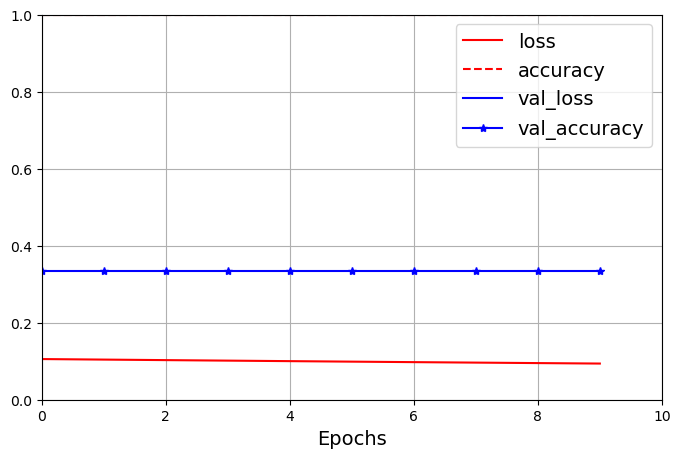

In [33]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5),
    xlim=[0, 10], ylim=[0, 1], xlabel='Epochs', grid=True,
    style=['r', 'r--', 'b', 'b-*'])
plt.show()

In [44]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 33ms/step - loss: 1.3155 - accuracy: 0.3333


[1.3155349493026733, 0.3333333432674408]

In [45]:
y_proba = model.predict(X_test)
y_proba.round(2)

1/1 [==============================] - 0s 38ms/step


array([[0.46, 0.24, 0.  , 0.02, 0.03, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01,
        0.  , 0.02, 0.02, 0.01, 0.02, 0.  , 0.  , 0.  , 0.03, 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.01, 0.01, 0.02, 0.  , 0.  , 0.02, 0.01],
       [0.33, 0.28, 0.01, 0.03, 0.04, 0.02, 0.  , 0.02, 0.01, 0.02, 0.01,
        0.01, 0.02, 0.02, 0.01, 0.02, 0.01, 0.  , 0.  , 0.04, 0.  , 0.  ,
        0.  , 0.01, 0.01, 0.01, 0.01, 0.02, 0.  , 0.01, 0.02, 0.01],
       [0.5 , 0.23, 0.  , 0.02, 0.04, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01,
        0.  , 0.02, 0.01, 0.01, 0.02, 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.01, 0.01, 0.02, 0.  , 0.  , 0.02, 0.01],
       [0.48, 0.27, 0.  , 0.02, 0.03, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01,
        0.  , 0.02, 0.01, 0.  , 0.01, 0.01, 0.  , 0.  , 0.02, 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.01, 0.01],
       [0.32, 0.16, 0.01, 0.02, 0.04, 0.02, 0.01, 0.03, 0.01, 0.03, 0.01,
        0.01, 0.03, 0.03, 0.01, 0.03, 0.01, 0.01, 0.  , 0.